In [17]:
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import awkward as ak
import atlas_mpl_style as ampl
ampl.use_atlas_style()  
import torch
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [18]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from imcal import *

In [19]:

#These are variables to change
CUT = True

LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]
TEST_N_EVENTS = 15000


"""
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"]
PLOT_LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL"]
FOLDERS = ["sph"]
"""
if CUT:
    VAL_N_EVENTS = [20000, 15000, 6000, 15000, 7000, 15000]
    N_MIN = 5
    ST_MIN = 7 #TeV
    ETA_MAX = 2.4
    PT_MIN = 70 #GeV

    VAL_CUT_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{folder}/50/{label}_test_res50_STmin7_Nmin5_3000_events.h5" for label, folder in zip(LABELS, FOLDERS)]
        
else:
    VAL_N_EVENTS = [3000]*len(LABELS)

DATA_PATH = "/disk/atlas3/data_MC/delphes/"

#Set data paths
VAL_FILENAMES = [f"{label}_{n}events.root" for label, n in zip(LABELS, VAL_N_EVENTS)]
VAL_DATAPATHS = [f"{DATA_PATH}/{VAL_FILENAME}" for VAL_FILENAME in VAL_FILENAMES]

DEVICE = torch.device("cpu")

In [20]:
def load_cut_event_numbers(hdf5file):
    with h5py.File(hdf5file, 'r') as f:
        keys = list(f.keys())
        data = [f[key]["event_id"] for key in keys]
        #create array
        ids = np.array(data).flatten()
        ids = ids.tolist()
        ids = [int(item[0]) for item in ids]
    return ids

In [21]:
#Open file in with-function will close it when you exit

def get_arrays(data_paths, n_events, id_paths=None):
    clusters = [load_data(f"{path}:Delphes", "Tower", 
                            ["Tower.ET", "Tower.Eta", "Tower.Phi", "Tower.Eem", "Tower.Ehad", "Tower.E"], n) for n, path in zip(n_events, data_paths)]
    
    tracks = [load_data(f"{path}:Delphes", "Track", 
                        ["Track.PT", "Track.Eta", "Track.Phi"], n) for n, path in zip(n_events, data_paths)]
    
    jets = [load_data(f"{path}:Delphes", "Jet", 
                            ["Jet.PT", "Jet.Eta", "Jet.Phi"], n) for n, path in zip(n_events, data_paths)]
    
    event_numbers = [load_data(f"{path}:Delphes", "Event", 
                            ["Event.Number"], n) for n, path in zip(n_events, data_paths)]
    print(data_paths)
    if CUT:
        cut_event_ids = [load_cut_event_numbers(id_path) for id_path in id_paths]    
        print(f"Events before cut: {[len(item) for item in clusters]}")
        event_ids = [ak.to_numpy(ar["Number"]).flatten() for ar in event_numbers]
        matching_ids = [np.argwhere(np.isin(ids, cut_ids)).ravel() for ids, cut_ids in zip(event_ids, cut_event_ids)]


    return matching_ids, jets, clusters, tracks

if CUT:
    event_ids, jets, clusters, tracks = get_arrays(VAL_DATAPATHS, VAL_N_EVENTS, VAL_CUT_DATAPATHS)

else:
    event_ids, jets, clusters, tracks = get_arrays(VAL_DATAPATHS)

['/disk/atlas3/data_MC/delphes//PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_20000events.root', '/disk/atlas3/data_MC/delphes//BH_n4_M8_15000events.root', '/disk/atlas3/data_MC/delphes//BH_n2_M10_6000events.root', '/disk/atlas3/data_MC/delphes//BH_n4_M10_15000events.root', '/disk/atlas3/data_MC/delphes//BH_n6_M10_7000events.root', '/disk/atlas3/data_MC/delphes//BH_n4_M12_15000events.root']
Events before cut: [20000, 15000, 6000, 15000, 7000, 15000]


tensor(0.9473)
tensor(0.9457)
tensor(0.9554)
tensor(0.9476)
tensor(0.9424)
tensor(0.9480)
tensor(0.9450)
tensor(0.9485)
tensor(0.9474)
tensor(0.9590)
tensor(0.9392)
tensor(0.9452)
tensor(0.9574)
tensor(0.9492)
tensor(0.9505)
tensor(0.9513)
tensor(0.9480)
tensor(0.9520)


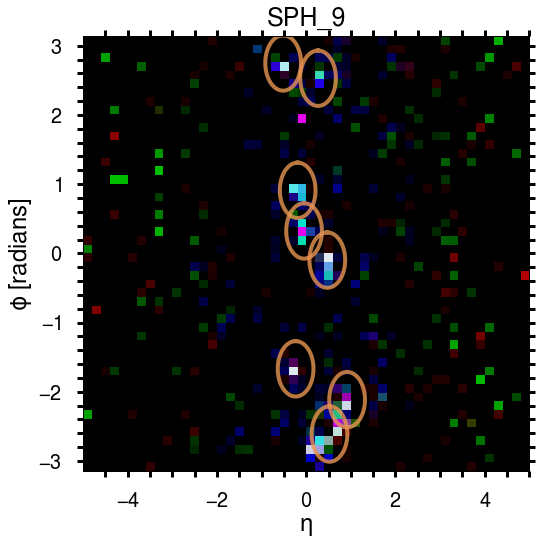

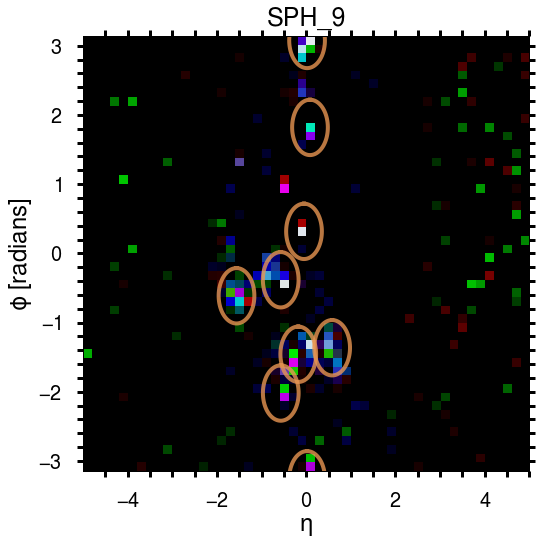

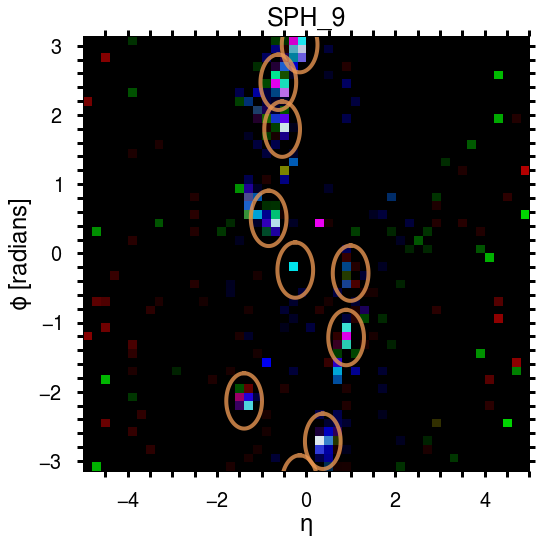

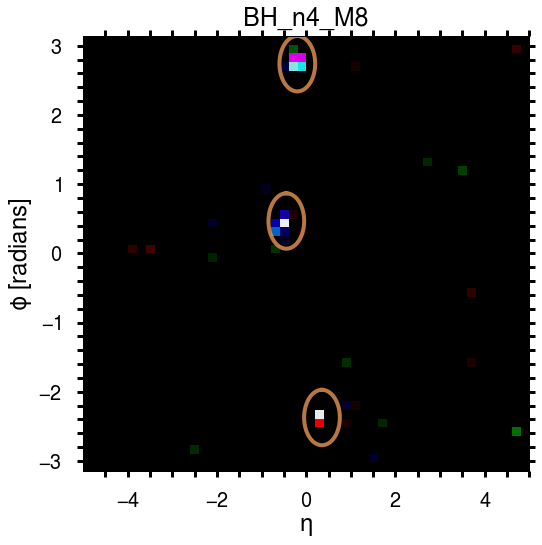

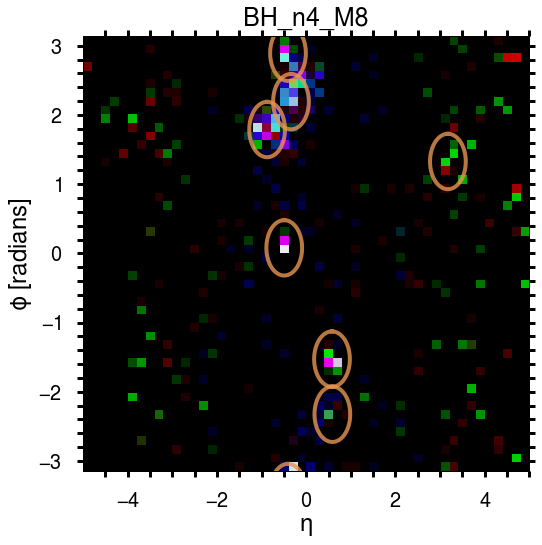

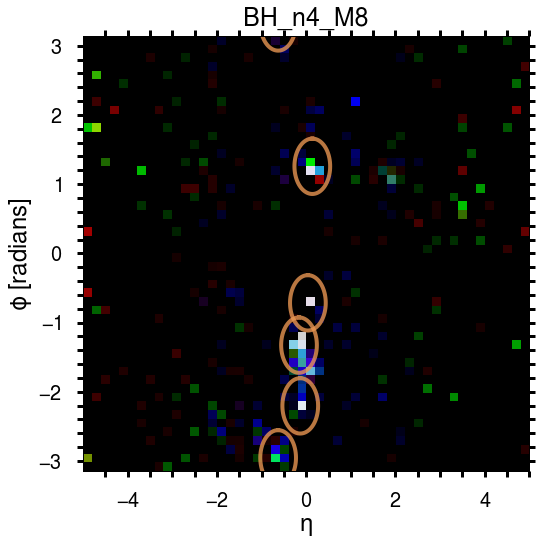

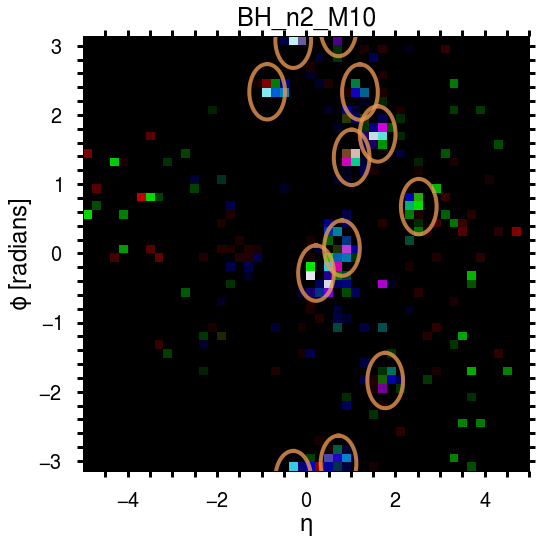

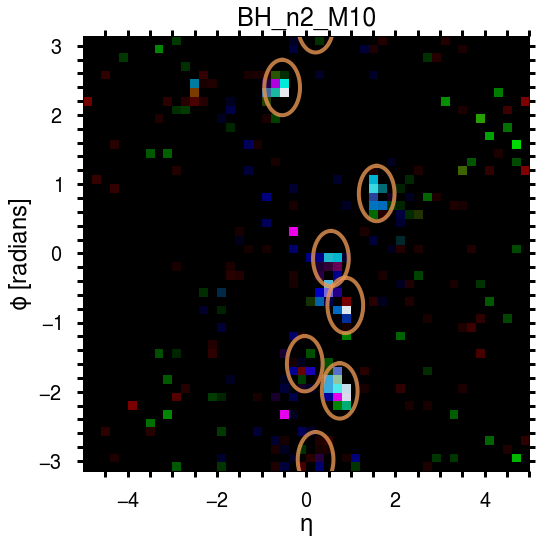

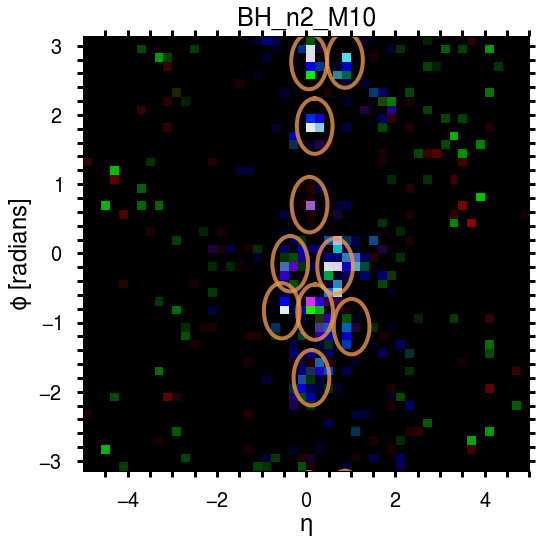

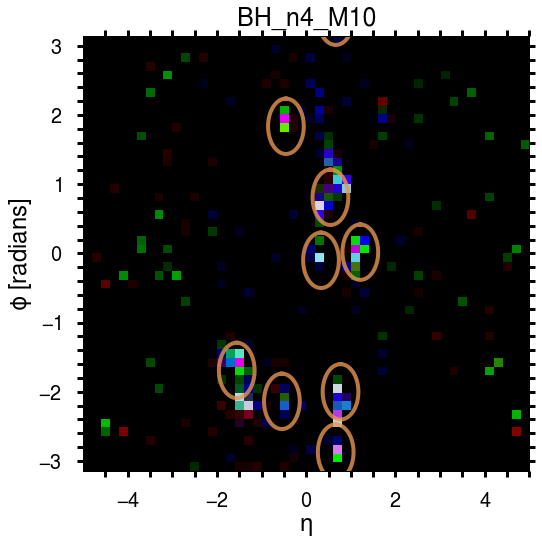

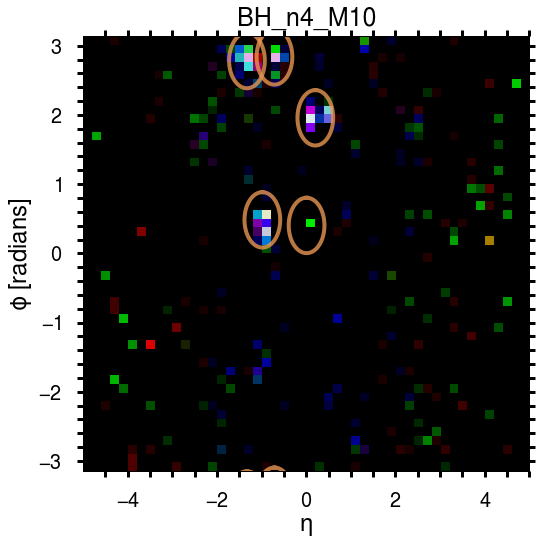

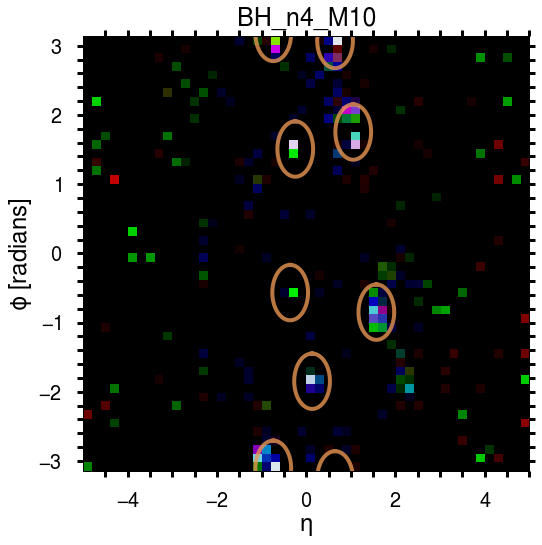

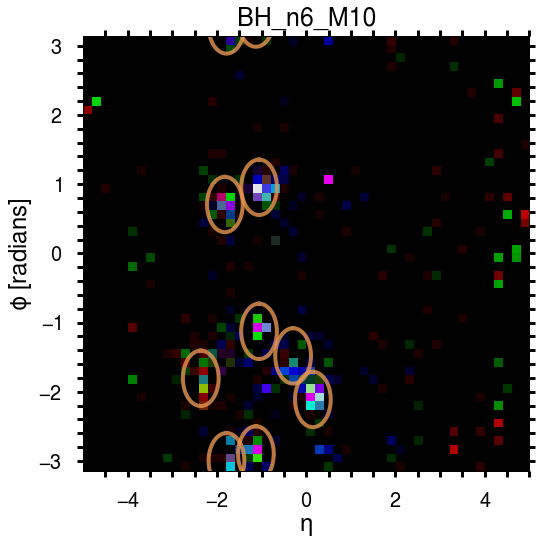

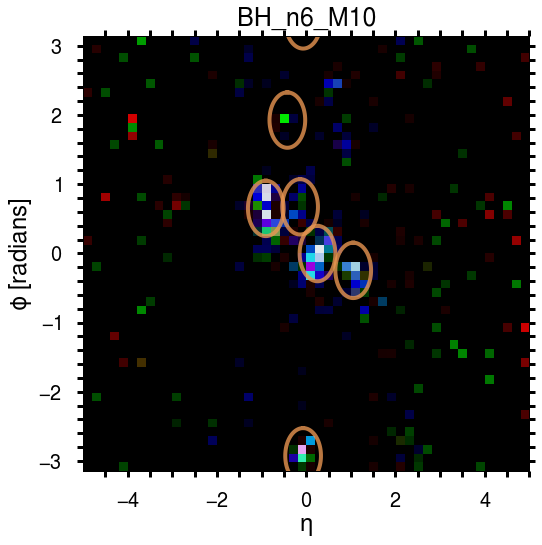

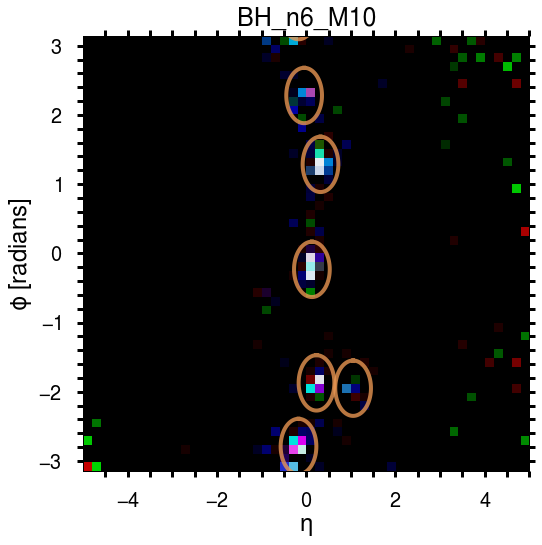

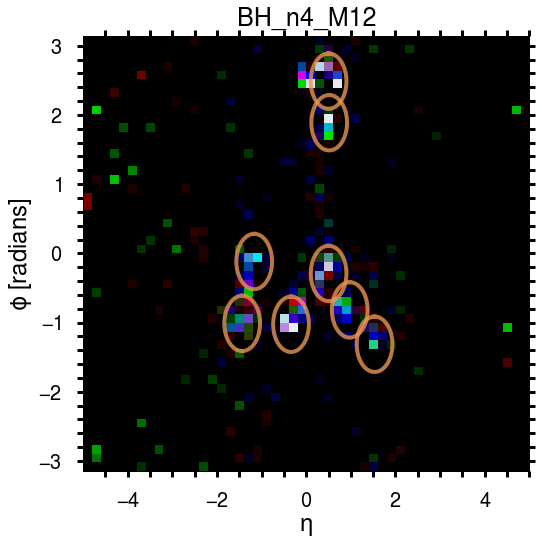

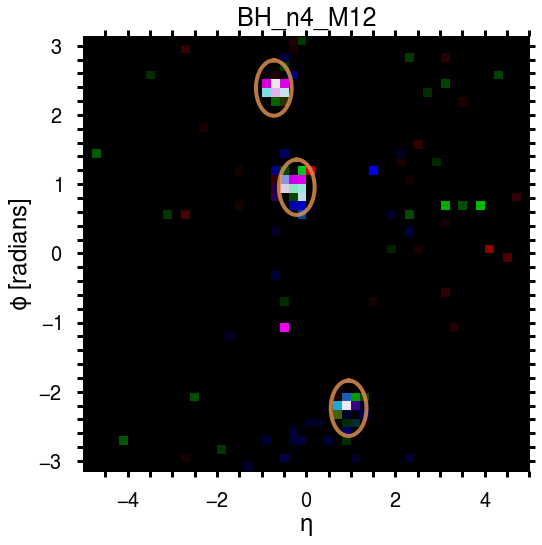

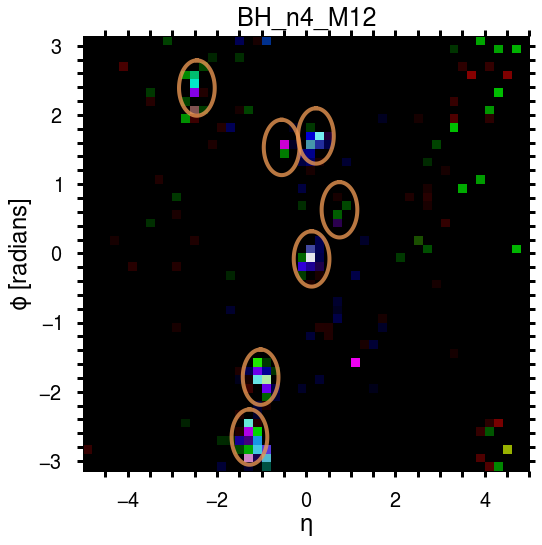

In [34]:
image_idx = [[1, 2, 3] for i in range(len(LABELS))]

for i, label in enumerate(LABELS):
    #Pad Tower data
    max_hits = np.max([len(event) for event in clusters[i]["Eta"]])
    new_clusters = ak.pad_none(clusters[i], max_hits, axis=-1)

    #Pad track data
    max_hits = np.max([len(event) for event in tracks[i]["Eta"]])
    new_tracks = ak.pad_none(tracks[i], max_hits, axis=-1)

    MAX_EVENTS = 1000
    RESOLUTION = 50
    hists_Eem = create_histograms(ak.to_numpy(new_clusters.Phi), ak.to_numpy(new_clusters.Eta), 
                                    ak.to_numpy(new_clusters.Eem), MAX_EVENTS, RESOLUTION)
    hists_Ehad = create_histograms(ak.to_numpy(new_clusters.Phi), ak.to_numpy(new_clusters.Eta), 
                                    ak.to_numpy(new_clusters.Ehad), MAX_EVENTS, RESOLUTION)
    hists_tracks = create_histograms(ak.to_numpy(new_tracks.Phi), ak.to_numpy(new_tracks.Eta), 
                                        ak.to_numpy(new_tracks.PT), MAX_EVENTS, RESOLUTION)
    #Stack to 3 channel
    images = np.stack((hists_Eem, hists_Ehad, hists_tracks), axis=-1)
    for k in image_idx[i]:
        id = event_ids[i][k]
        image = images[id]

        fig, ax = plt.subplots(ncols=1, figsize=(8, 8))
        ax.set_title(f"{PLOT_LABELS[i]}", fontsize=25, pad=10)

        test_image = torch.Tensor(images[id])
        test_image[:,:,2] = 6*test_image[:,:,2]
        new_image = torch.arctan(torch.log(test_image/20))/torch.pi + 0.5
        print(torch.max(new_image))

        ax.imshow(new_image, extent=[-5, 5, -np.pi, np.pi], aspect='auto')
        cal_image_plot_paper(ax)
        ax.set_xlim(-5, 5)
        ax.set_ylim(-np.pi, np.pi)
        ax.tick_params(which="both", direction="out", bottom=True, left=True, labelsize=20, pad=15, length=6, width=3)

        #draw a circle where jets are
        jet_eta = jets[i]['Eta'][id]
        jet_phi = jets[i]['Phi'][id]
        for eta, phi in zip(jet_eta, jet_phi):
            r= 0.4
            angles = np.linspace(0 * np.pi, 2 * np.pi, 100 )
            ys = r*np.cos(angles) - phi
            xs = r*np.sin(angles) + eta
            ys_wrap = ys[abs(ys)>np.pi]
            xs_wrap = xs[abs(ys)>np.pi]
            ax.plot(xs, ys, color = '#e99652', linewidth=4, alpha=0.8)
            if len(ys_wrap)>0:
                if ys_wrap[0]>0:
                    ax.plot(xs_wrap, -np.pi + (ys_wrap - np.pi) -0.05, color = '#e99652', linewidth=4, alpha=0.8)
                else:
                    ax.plot(xs_wrap, np.pi + (ys_wrap + np.pi), color = '#e99652', linewidth=4, alpha=0.8)

        fig.savefig(f"../results/figures/event_image_{label}_{id}.pdf", format="pdf",bbox_inches='tight')
    


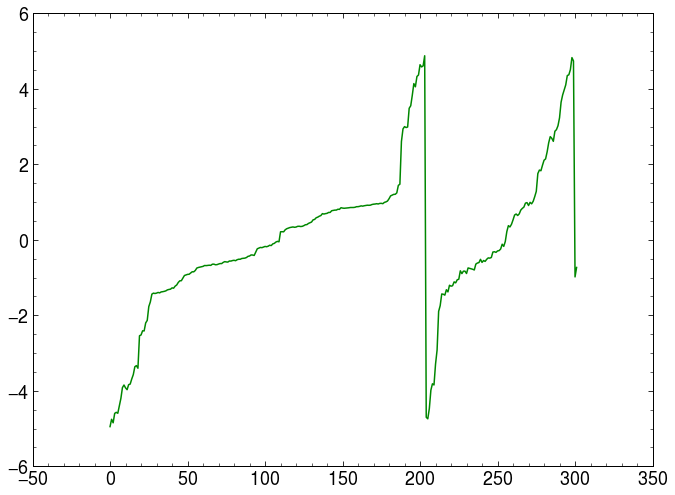

In [24]:
plt.plot(clusters[0]['Eta'][id])

In [25]:

np.set_printoptions(precision=5, suppress=True)
print("Ehad energy: \n")
print(f"{np.array(clusters[0]['Ehad'][id])}")
print("\n Eem energy: \n")
print(f"{np.array(clusters[0]['Eem'][id], dtype='float')}")
print("\n Eta: \n")
print(f"{np.array(clusters[0]['Eta'][id])}")
print("\n Phi: \n")
print(f"{np.array(clusters[0]['Phi'][id])}")
print("\n -------------- ")
print("-------------- \n")
print("\n Track energy: \n")
print(f"{np.array(tracks[0]['PT'][id])}")
print("\n Track Eta: \n")
print(f"{np.array(tracks[0]['Eta'][id])}")
print("\n Track Phi: \n")
print(f"{np.array(tracks[0]['Phi'][id])}")
 

Ehad energy: 

[  0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.        0.
   0.        0.        0.        0.        0.        0.      

In [26]:

"""
filename = f"{LABELS[0]}_eventid_{id}_cluster_values"
file = open(f"../results/{filename}.txt", "w")
file.write("Ehad energy: \n")
file.write(f"{np.array(clusters[0]['Ehad'][id])}")
file.write("\n Eem energy: \n")
file.write(f"{np.array(clusters[0]['Eem'][id], dtype='float')}")
file.write("\n Eta: \n")
file.write(f"{np.array(clusters[0]['Eta'][id])}")
file.write("\n Phi: \n")
file.write(f"{np.array(clusters[0]['Phi'][id])}")
file.write("\n -------------- ")
file.write("-------------- \n")
file.write("\n Track energy: \n")
file.write(f"{np.array(tracks[0]['PT'][id])}")
file.write("\n Track Eta: \n")
file.write(f"{np.array(tracks[0]['Eta'][id])}")
file.write("\n Track Phi: \n")
file.write(f"{np.array(tracks[0]['Phi'][id])}")

file.close()

    """

'\nfilename = f"{LABELS[0]}_eventid_{id}_cluster_values"\nfile = open(f"../results/{filename}.txt", "w")\nfile.write("Ehad energy: \n")\nfile.write(f"{np.array(clusters[0][\'Ehad\'][id])}")\nfile.write("\n Eem energy: \n")\nfile.write(f"{np.array(clusters[0][\'Eem\'][id], dtype=\'float\')}")\nfile.write("\n Eta: \n")\nfile.write(f"{np.array(clusters[0][\'Eta\'][id])}")\nfile.write("\n Phi: \n")\nfile.write(f"{np.array(clusters[0][\'Phi\'][id])}")\nfile.write("\n -------------- ")\nfile.write("-------------- \n")\nfile.write("\n Track energy: \n")\nfile.write(f"{np.array(tracks[0][\'PT\'][id])}")\nfile.write("\n Track Eta: \n")\nfile.write(f"{np.array(tracks[0][\'Eta\'][id])}")\nfile.write("\n Track Phi: \n")\nfile.write(f"{np.array(tracks[0][\'Phi\'][id])}")\n\nfile.close()\n\n    '